In [33]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("/home/darth/projects/bopt")
sys.path.append("/Users/arnoljak/projects/bopt")

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

import bopt

from bopt.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from bopt.gaussian_process import GaussianProcess
from bopt.bayesian_optimization import bo_plot_exploration, bo_maximize_loop, Integer, Float
from bopt.bayesian_optimization import plot_2d_optim_result
from bopt.acquisition_functions import expected_improvement, probability_of_improvement
from bopt.bayesian_optimization import propose_location
from bopt.opt_functions import get_opt_test_functions
from bopt.plot import plot_gp, plot_kernel_loss, plot_kernel_loss_2d

import GPy
import sklearn.gaussian_process as skproc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Broken kernel


In [132]:
def kernel_plot(lbfgs = False, use_tf = False):
    bopt.clear_param_traces()
    os.environ["USE_LBFGS"] = "1" if lbfgs else "0"
    os.environ["USE_TF"] = "1" if use_tf else "0"

    gp = bopt.GaussianProcess(kernel=result.kernel) \
        .fit(X, y) \
        .optimize_kernel()
    
    plt.figure(figsize=(16, 5))
    U_LB = os.environ.get("USE_LBFGS", False)
    U_TF = os.environ.get("USE_TF", False)

    plt.suptitle(f"LBFGS={U_LB} TF={U_TF}   noise={round(gp.noise, 2)} {gp.kernel}", fontsize=20)

    plt.subplot(131)
    bopt.plot_2d_optim_result(result, gp=gp)
    
    param_traces = bopt.kernel_opt.get_param_traces()

    nll_trace = param_traces["nll"]
    param_traces.pop("nll")

    plt.subplot(132)
    for name, vals in param_traces.items():
        plt.plot(vals, label=name)
    plt.subplot(133)
    plt.plot(nll_trace)
    plt.show()

1.299344    1.070166    0.683830    42.136875
1.284370    1.058876    0.674869    42.018840
1.268904    1.051086    0.667243    41.913094
1.252919    1.049030    0.660961    41.810833
1.236405    1.055182    0.655649    41.700764
1.219298    1.070297    0.650670    41.569845
1.201496    1.091993    0.645337    41.405741
1.182912    1.117274    0.639154    41.197979
1.163500    1.144418    0.631875    40.936178
1.143250    1.172673    0.623396    40.608478
1.122188    1.201726    0.613662    40.200767
1.100366    1.231431    0.602627    39.696325
1.077866    1.261704    0.590274    39.075937
1.054797    1.292466    0.576637    38.318768
1.031298    1.323622    0.561829    37.404412
1.007543    1.355035    0.546054    36.316372
0.983736    1.386523    0.529594    35.046705
0.960104    1.417861    0.512777    33.600633
0.936880    1.448790    0.495936    31.999260
0.914287    1.479038    0.479370    30.278775
0.892515    1.508346    0.463326    28.485851
0.871710    1.536491    0.447980  

0.295394    0.795509    0.194305    -3.429889
0.295227    0.794808    0.194296    -3.430134
0.295071    0.794157    0.194288    -3.430344
0.294927    0.793551    0.194280    -3.430523
0.294792    0.792990    0.194273    -3.430676
0.294668    0.792469    0.194266    -3.430806
0.294552    0.791986    0.194260    -3.430917
0.294445    0.791540    0.194254    -3.431011
0.294346    0.791127    0.194249    -3.431091
0.294254    0.790747    0.194244    -3.431158
0.294169    0.790395    0.194240    -3.431215
0.294091    0.790071    0.194236    -3.431262
0.294020    0.789773    0.194232    -3.431302
0.293954    0.789499    0.194228    -3.431336
0.293893    0.789248    0.194225    -3.431364
0.293837    0.789017    0.194222    -3.431387
0.293786    0.788805    0.194219    -3.431407
0.293739    0.788611    0.194217    -3.431423
0.293696    0.788434    0.194215    -3.431436
0.293657    0.788272    0.194213    -3.431447


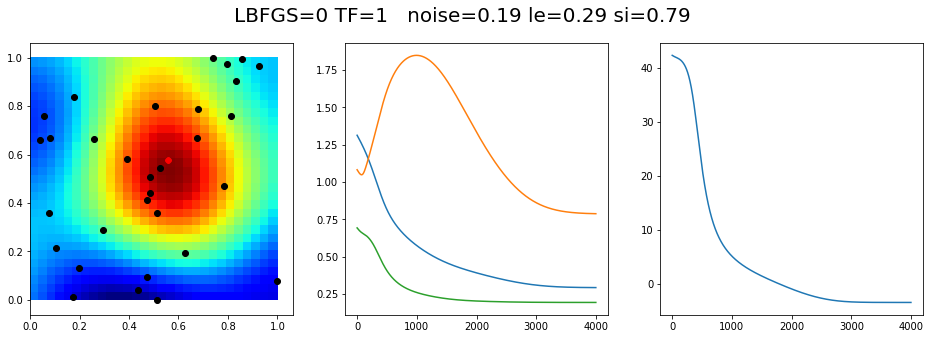

0.295306    0.902813    0.251903    -0.933535


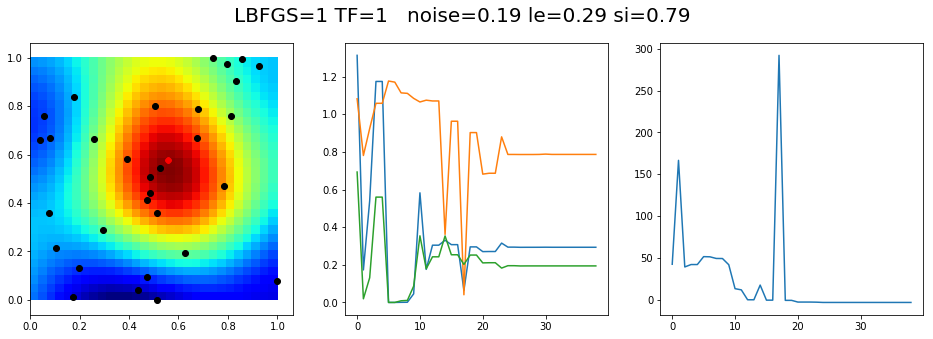

1.082458    1.313272    0.693157    40.618424
0.464332    1.472407    0.153507    6.745044
0.259324    0.722762    0.186155    -3.030220
0.293291    0.786757    0.194193    -3.431496


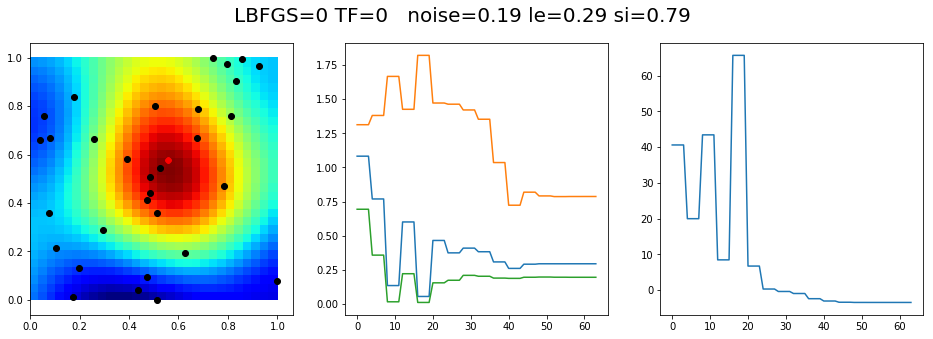

In [135]:
exp = bopt.Experiment.deserialize("results/mc")
result = exp.current_optim_result()

X = result.X_sample
y = result.y_sample

y = (y - y.mean()) / y.std()

kernel_plot(use_tf=True, lbfgs=False)
kernel_plot(use_tf=True, lbfgs=True)
kernel_plot(use_tf=False)

# 1d comparison with GPy

In [235]:
def model_bopt():
    gp = GaussianProcess(noise=1.0, kernel=SquaredExp(l=1.0, sigma=1.0)).fit(X_train, y_train)\
      .optimize_kernel().posterior(X)
    
    params = {
        "noise": gp.noise,
        "ls": gp.kernel.params["lengthscale"].numpy().item(),
        "sigma": gp.kernel.params["sigma"].numpy().item()
    }
    
    return gp.mu, gp.cov, params, gp.log_prob().numpy().item()

    
def model_gpy():
    rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
    gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

    gpr.optimize()

    mu, cov = gpr.predict(X, full_cov=True)
    
    params = {
        "noise": float(gpr.Gaussian_noise.variance),
        "ls": gpr.rbf.lengthscale.values[0],
        "sigma": np.sqrt(gpr.rbf.variance.values[0])
    }
    
    nll = -gpr.log_likelihood()
    
    return mu.reshape(-1), cov, params, nll

In [236]:
params = [0.1, 0.3]

X_train = np.array([2,2.01,3], dtype=np.float64).reshape(-1, 1)
y_train = np.array([2,3,5], dtype=np.float64)

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01).reshape(-1, 1)

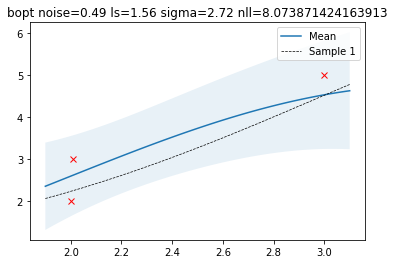

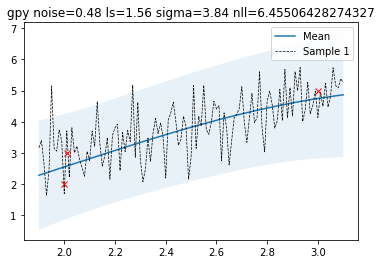

In [237]:
model_options = [
    ("bopt", model_bopt()),
    ("gpy", model_gpy())
]

for name, (mu, cov, params, nll) in model_options:
#     mu, cov, params = model()
    
    param_str = " ".join([f"{name}={round(value, 2)}" for name, value in params.items()])
    
    plt.figure()
    plt.title(name + " " + param_str + f" nll={nll}")
    plot_gp(mu.reshape(-1), cov, X.reshape(-1), X_train.reshape(-1),
            y_train.reshape(-1), num_samples=1, figure=False)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f1ce81f9c88>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f1ce81f9ba8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f1ce82021d0>]}

 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


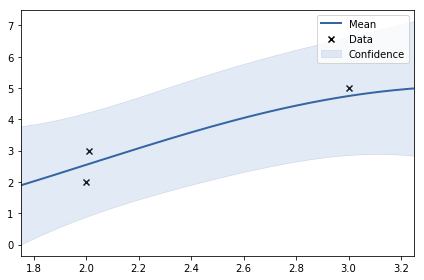

In [238]:
rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
gpr.plot()

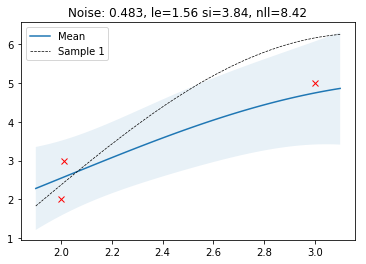

In [239]:
def gpy_to_bopt():
    _, _, gpy_params, nll = model_gpy()

    gp = GaussianProcess(noise=gpy_params["noise"],
                     kernel=SquaredExp(l=gpy_params["ls"], sigma=gpy_params["sigma"]))\
      .fit(X_train, y_train)
    
    return gp

# BOPT plot using exactly the same GPY params
gpy_to_bopt().posterior(X).plot_posterior(figsize=(6,4), num_samples=1)

In [240]:
m1, c1, _, nll1 = model_bopt()
m2, c2, _, nll2 = model_gpy()

print("max mean diff", max(m1 - m2))
print("nll diff", nll1 - nll2)
print()
print(c1 - c2)

max mean diff 0.07062851349372323
nll diff 1.6188071414206435

[[-0.5001966  -0.01595893 -0.01497776 ...  0.01420182  0.01372526
   0.01323964]
 [-0.01595893 -0.49829975 -0.01415339 ...  0.01432139  0.01390847
   0.01348725]
 [-0.01497776 -0.01415339 -0.49658343 ...  0.01443277  0.01408278
   0.01372523]
 ...
 [ 0.01420182  0.01432139  0.01443277 ... -0.52058727 -0.03827323
  -0.03921135]
 [ 0.01372526  0.01390847  0.01408278 ... -0.03827323 -0.52253378
  -0.04030488]
 [ 0.01323964  0.01348725  0.01372523 ... -0.03921135 -0.04030488
  -0.52465264]]


## 2d data - BOPT vs GPY

...le=0.29 si=0.79 0.1941933085783507 nll=-3.43


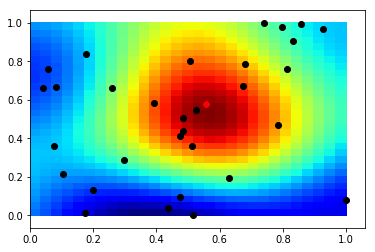

-24.077623531994096
...le=1.56 si=3.84 0.4832485485668933 nll=35.8


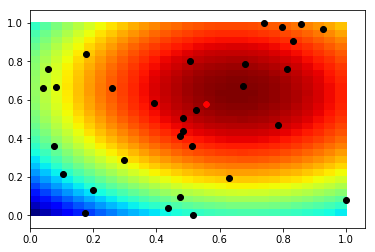

In [254]:
exp = bopt.Experiment.deserialize("results/mc")
result = exp.current_optim_result()

X_train = result.X_sample
y_train = result.y_sample

y_train = (y_train - y_train.mean()) / y_train.std()

model_options = [
    ("bopt", model_bopt),
    ("gpy", model_gpy)
]

gp = bopt.GaussianProcess(kernel=result.kernel) \
    .fit(X_train, y_train) \
    .optimize_kernel()

bopt.plot_2d_optim_result(result, gp=gp)
plt.show()

rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

params = {
    "noise": float(gpr.Gaussian_noise.variance),
    "ls": gpr.rbf.lengthscale.values[0],
    "sigma": np.sqrt(gpr.rbf.variance.values[0])
}

gp = GaussianProcess(noise=gpy_params["noise"],
                     kernel=SquaredExp(l=gpy_params["ls"], sigma=gpy_params["sigma"]))\
        .fit(X_train, y_train)

bopt.plot_2d_optim_result(result, gp=gp)
plt.show()

# for name, model in model_options:
#     mu, cov, params = model()
    
#     param_str = " ".join([f"{name}={round(value, 2)}" for name, value in params.items()])
    
#     plt.figure()
#     plt.title(name + " " + param_str)
# #    plot_gp(mu.reshape(-1), cov, X.reshape(-1), X_train.reshape(-1),
# #            y_train.reshape(-1), num_samples=1, figure=False)

-24.077623531994096


 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f1c9132e5f8>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f1c9132e668>]}

 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


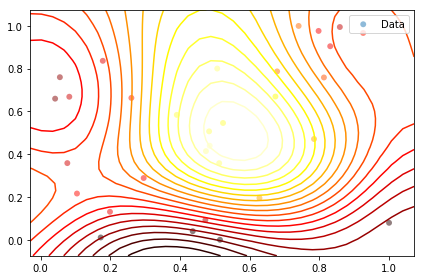

In [255]:
rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

gpr.plot()

In [ ]:
## useless

def model_sklearn():
    rbf = skproc.kernels.ConstantKernel(1.0) \
            * skproc.kernels.RBF(length_scale=1.0) \
            * skproc.kernels.WhiteKernel(1.0)

    gpr = skproc.GaussianProcessRegressor(kernel=rbf, alpha=1.)
    gpr.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

    mu, cov = gpr.predict(X.reshape(-1, 1), return_cov=True)

    kernel_sigma = gpr.kernel_.k1.k1
    kernel_ls = gpr.kernel_.k1.k2
    kernel_noise = gpr.kernel_.k2
    
    params = {
        "noise": kernel_noise.noise_level,
        "ls": kernel_ls.length_scale,
        "sigma": np.sqrt(kernel_sigma.constant_value)
    }
    
    return mu, cov, params

In [10]:
rbf.K(X_train.reshape(-1, 1), X_train.reshape(-1, 1))

array([[14.78248556, 14.78218135, 12.03294434],
       [14.78218135, 14.78248556, 12.0823241 ],
       [12.03294434, 12.0823241 , 14.78248556]])

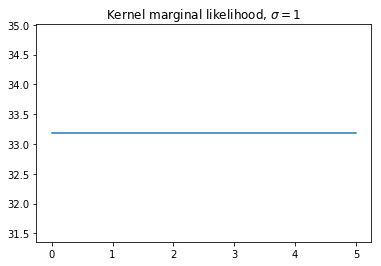

In [11]:
class GPyWrapper:
    def __init__(self):
        self.params = None
        
    def set_params(self, params):
        self.params = params
        return self
        
    def __call__(self, a, b):
        return GPy.kern.RBF(input_dim=1, variance=1., lengthscale=params[0]).K(a.reshape(-1, 1), b.reshape(-1, 1))

plot_kernel_loss(GPyWrapper(), X_train, y_train)

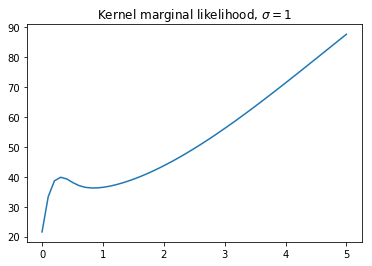

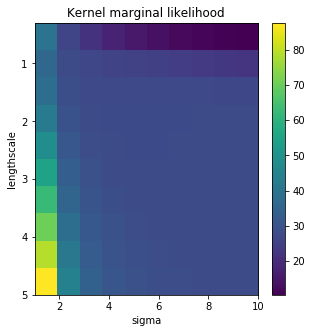

In [12]:
kernel = SquaredExp(sigma=0.001)
plot_kernel_loss(kernel, X_train, y_train)
plot_kernel_loss_2d(kernel, X_train, y_train)

# Big data

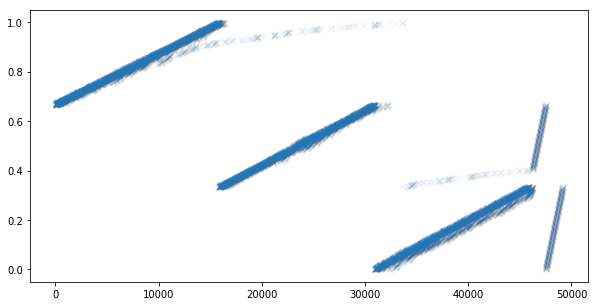

In [15]:
values = np.genfromtxt("../data/matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [16]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

In [17]:
def fit_with_scale(X, y, scale):
    y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
    X = np.array(list(range(len(y)))) / scale

    gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
    gp.plot_posterior(num_samples=0)


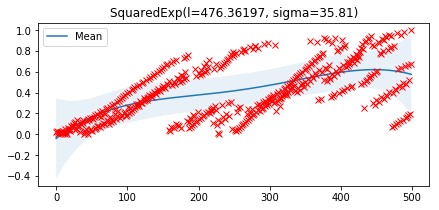

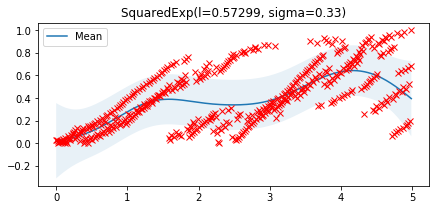

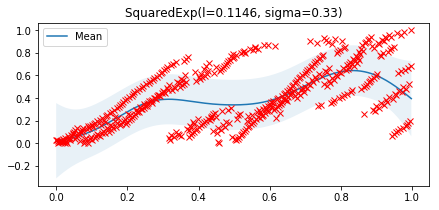

In [18]:
def foo():
    for i in [1,100, 500]:
        fit_with_scale(X, y, i)
        plt.show()
        
%prun foo()

# TODO Gaussian likelihood for a given covariance

# TODO Gaussian likelihood for a given covariance

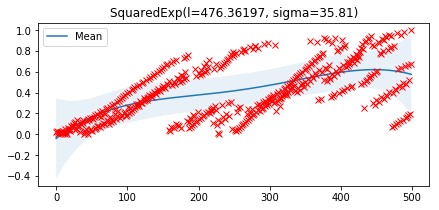

In [19]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

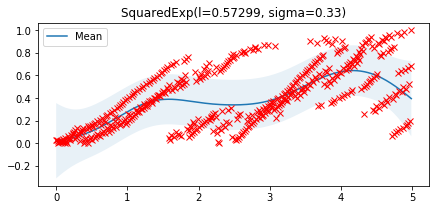

In [20]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

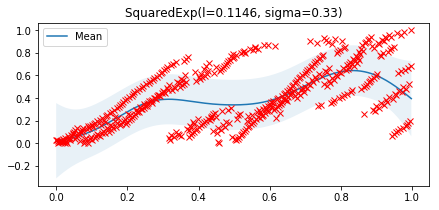

In [21]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/500

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

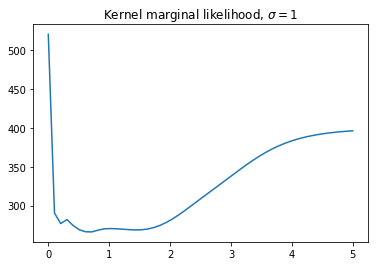

In [22]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

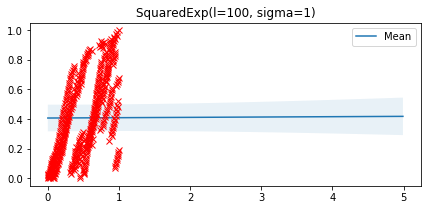

In [23]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)

## Stare data

In [138]:
noise = 1

params = [0.1, 0.3]#, 0.6, 0.9]

#X_train = np.array([0, 0.02, 0.05, 0.3, 0.4,1,1.1,1.2,1.3,1.4,2,3,4])

X_train = np.array([2,2.01,3], dtype=np.float64).reshape(-1, 1)  #, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
y_train = np.array([2,3,5], dtype=np.float64)

# X_train = np.array([2,2.01,2.02,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
# y_train = np.array([2,3,2,100])

# y_train[1] = .6
# y_train[2] = 1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01).reshape(-1, 1)